In [0]:
import numpy as np
import matplotlib.pyplot as plt
import h5py 
import os
import tensorflow as tf
import keras
import keras.backend as K
K.set_image_data_format('channels_last')
from keras.utils import plot_model
from keras import regularizers

%matplotlib inline

In [0]:
os.chdir('drive/My Drive/Dataset')

In [0]:
def Load_Data():
  
  train_dataset = h5py.File('train_signs.h5','r')
  test_dataset = h5py.File('test_signs.h5','r')
  
  train_set_X_orig = np.array(train_dataset['train_set_x'][:])
  train_set_Y_orig = np.array(train_dataset['train_set_y'][:])
  test_set_X_orig = np.array(test_dataset['test_set_x'][:])
  test_set_Y_orig = np.array(test_dataset['test_set_y'][:])
  
  classes = np.array(test_dataset['list_classes'][:])
  
  return train_set_X_orig,train_set_Y_orig,test_set_X_orig,test_set_Y_orig,classes

(1080, 64, 64, 3) (1080,) (120, 64, 64, 3) (120,)
y = 1. It is the number 1


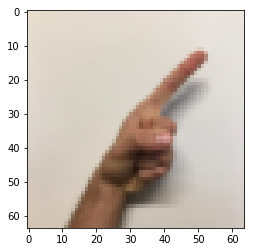

In [49]:
train_set_X_orig,train_set_Y_orig,test_set_X_orig,test_set_Y_orig,classes = Load_Data()

print(train_set_X_orig.shape,train_set_Y_orig.shape,test_set_X_orig.shape,test_set_Y_orig.shape)
i = 9
plt.imshow(test_set_X_orig[i])
print('y = '+str(test_set_Y_orig[i])+'. It is the number '+str(test_set_Y_orig[i]))

In [0]:
def Reshape_And_Normalize(train_set_X_orig,train_set_Y_orig,test_set_X_orig,test_set_Y_orig):
  
  train_set_X = train_set_X_orig/255
  test_set_X = test_set_X_orig/255
  train_set_Y = train_set_Y_orig.reshape((train_set_Y_orig.shape[0],1))
  test_set_Y = test_set_Y_orig.reshape((test_set_Y_orig.shape[0],1))
  
  return train_set_X,train_set_Y,test_set_X,test_set_Y

In [0]:
def Data_Preprocessing():
  
  train_set_X_orig,train_set_Y_orig,test_set_X_orig,test_set_Y_orig,classes = Load_Data()
  train_set_X,train_set_Y,test_set_X,test_set_Y = Reshape_And_Normalize(train_set_X_orig,train_set_Y_orig,test_set_X_orig,test_set_Y_orig)
  
  return train_set_X,train_set_Y,test_set_X,test_set_Y

In [0]:
def Propagation(input_shape,channels,layers_dims,filter_conv,filter_pool,stride_conv,stride_pool,padding,keep_prob_conv,keep_prob_fully):
  
  X_input = keras.layers.Input(input_shape)
  X = X_input
  L = len(channels)
  
  for l in range(1,L):
    p = padding[l-1]
    s = stride_conv[l-1]
    f = filter_conv[l-1]
    X = keras.layers.ZeroPadding2D(padding=p)(X)
    X = keras.layers.Conv2D(channels[l],kernel_size=f,strides=s,name='Conv'+str(l),kernel_regularizer=regularizers.l2(0.01))(X)
    X = keras.layers.BatchNormalization(axis=3,name='BatchNorm_C'+str(l))(X)
    X = keras.layers.Activation('relu')(X)
    X = keras.layers.Dropout(rate=keep_prob_conv[l-1])(X)
    
    if(l%2 == 0):
      fp = filter_pool[int(l/2-1)]
      sp = stride_pool[int(l/2-1)]
      X =  keras.layers.MaxPooling2D(pool_size=fp,strides=sp,padding='valid',name='MaxPool'+str(l/2))(X)
   
  X = keras.layers.Flatten()(X)
  L = len(layers_dims)
  
  for l in range(L):
    
    if(l < L-1):
      activation = 'relu'
    else:
      if(layers_dims[l] == 1):
        activation = 'sigmoid'
      else:
        activation = 'softmax'
 
    X = keras.layers.BatchNormalization(axis=1,name='BatchNorm_F'+str(l+1))(X)
    X = keras.layers.Dense(layers_dims[l],activation=activation,kernel_initializer='glorot_uniform', bias_initializer='zeros',name='FullyConnected'+str(l+1),use_bias=True,kernel_regularizer=regularizers.l2(0.01))(X)
    X = keras.layers.Dropout(rate=keep_prob_fully[l])(X)
    
  model = keras.models.Model(inputs=X_input,outputs=X,name='CNN_Keras')
  
  return model

In [0]:
def Caller_Function():
  
  train_set_X,train_set_Y,test_set_X,test_set_Y = Data_Preprocessing()
  epochs = 2
  mini_batch_size = 2
  channels = [train_set_X.shape[3]]
  channels.extend([32,64])
  filter_conv = [(3,3),(3,3)]
  filter_pool = [(2,2)]
  stride_conv = [(1,1),(1,1)]
  stride_pool = [(2,2)]
  padding = [[0,0],[0,0]]
  layers_dims=[1024,6]
  keep_prob_conv = [1,1]
  keep_prob_fully = [1,1]
  train_set_Y = np.eye(layers_dims[len(layers_dims)-1])[train_set_Y.T][0]
  test_set_Y = np.eye(layers_dims[len(layers_dims)-1])[test_set_Y.T][0]
  shape = (train_set_X.shape)
  input_shape = (shape[1],shape[2],shape[3])
  
  
  model = Propagation(input_shape,channels,layers_dims,filter_conv,filter_pool,stride_conv,stride_pool,padding,keep_prob_conv,keep_prob_fully)
  model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
  model.fit(x=train_set_X[0:50,:,:,:],y=train_set_Y[0:50,:],epochs=epochs,batch_size=mini_batch_size)
  print('')
  preds = model.evaluate(x=train_set_X[0:10,:,:,:],y=train_set_Y[0:10,:])
  print("Train_Accuracy : "+str(preds[1]*100))
  print('')
  preds = model.evaluate(x=test_set_X[0:10,:,:,:],y=test_set_Y[0:10,:])
  print("Test_Accuracy : "+str(preds[1]*100))
  
  model.summary()
  print(model.predict(x=test_set_X[9:10,:]))

In [52]:
Caller_Function()

Epoch 1/2
50/50 [==============================] - 67s 1s/step - loss: 18.7187 - acc: 0.2600
Epoch 2/2
50/50 [==============================] - 62s 1s/step - loss: 13.9892 - acc: 0.4400

10/10 [==============================] - 2s 184ms/step
Train_Accuracy : 30.000001192092896

10/10 [==============================] - 0s 37ms/step
Test_Accuracy : 20.000000298023224
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 64, 64, 3)         0         
_________________________________________________________________
zero_padding2d_21 (ZeroPaddi (None, 64, 64, 3)         0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 62, 62, 32)        896       
_________________________________________________________________
BatchNorm_C1 (BatchNormaliza (None, 62, 62, 32)        128       
______________________________________